# Garbage Classification
Dataset take from [Kaggle](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification) including 6 class and self-collection dataset. 
This notebook will solve Garbage Classification on total 8 class:

* Glass
* Metal
* Paper
* Cardboard
* Plastic
* Nilon
* Facemask
* Danger

Let's go using CNNs from Scratch.

## Prepare Data
___

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tqdm
import time
list1=[2,3,5,7,11,13,17,19,23,29]
for i in tqdm.tqdm(list1):
  time.sleep(1)

print("The end")

100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

The end


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import glob
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# im = PIL.Image.open("/content/drive/MyDrive/PBL5-Data/Garbage classification/cardboard/cardboard1.jpg",mode = "r")
# im
dataset_url = "/content/drive/MyDrive/PBL5-Data/Garbage classification"
#data_dir = tf.keras.utils.get_file('/content/drive/MyDrive/PBL5-Data/Garbage classification')
data_dir = pathlib.Path("/content/drive/MyDrive/PBL5-Data/Garbage Data")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
# cardboard = list(data_dir.glob('cardboard/*'))
# PIL.Image.open(str(cardboard[0]))
# PIL.Image.open(str(cardboard[1]))

3043


In [ ]:
batch_size = 32
img_height = 160
img_width = 160

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=70,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3043 files belonging to 8 classes.
Using 2435 files for training.


In [ ]:
# a = train_ds.choose_from_datasets(train_ds, 2)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=70,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3043 files belonging to 8 classes.
Using 608 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'danger', 'facemask', 'glass', 'metal', 'nilon', 'paper', 'plastic']


In [ ]:
for cl in class_names:
  !echo $cl && find "/content/drive/MyDrive/PBL5-Data/Garbage Data" | grep $cl/ | wc -l

cardboard
431
danger
33
facemask
106
glass
501
metal
436
nilon
256
paper
759
plastic
560


In [ ]:
for cl in class_names:
  !echo $cl && find "/content/drive/MyDrive/PBL5-Data/Garbage classification" | grep $cl/ | wc -l

cardboard
403
danger
0
glass
501
metal
410
paper
594
plastic
482
trash
137


In [ ]:
import os
import glob
!find "/content/drive/MyDrive/PBL5-Data/Garbage Data/facemask/" -name "*.jpg" |wc -l

100


In [ ]:
ft = []
for f in glob.glob("/content/drive/MyDrive/PBL5-Data/Garbage classification/glass/*"):
  !cp "$f" "/content/drive/MyDrive/PBL5-Data/Garbage Data/glass/"  #ask $
# !cp "/content/drive/MyDrive/PBL5-Data/Garbage classification/glass/glass1.jpg" "/content/drive/MyDrive/PBL5-Data/Garbage Data/glass/"

In [ ]:
for cl in class_names:
  for f in glob.glob(f"/content/drive/MyDrive/PBL5-Data/Garbage classification/{cl}/*"): 
    !cp "$f" "/content/drive/MyDrive/PBL5-Data/Garbage Data/$cl/"

In [ ]:
for f in glob.glob("/content/drive/MyDrive/PBL5-Data/Data/data_3/hop_giay/*"):
  !cp "$f" "/content/drive/MyDrive/PBL5-Data/Garbage Data/cardboard/"

In [ ]:
for cl in class_names:
  for f in glob.glob(f"/content/drive/MyDrive/PBL5-Data/Garbage Data/{cl}/*"): 
    if cl in ['cardboard', 'paper']:
      !cp "$f" "/content/drive/MyDrive/PBL5-Data/Garbage big class/BioDegradable/"
    elif cl in ['metal', 'nilon', 'glass', 'plastic']:
      !cp "$f" "/content/drive/MyDrive/PBL5-Data/Garbage big class/NonBioDegradable/"
    else:
      !cp "$f" "/content/drive/MyDrive/PBL5-Data/Garbage big class/Hazardous/"

In [ ]:
!find "/content/drive/MyDrive/PBL5-Data/Garbage Data/cardboard/" -name "*sao*" 

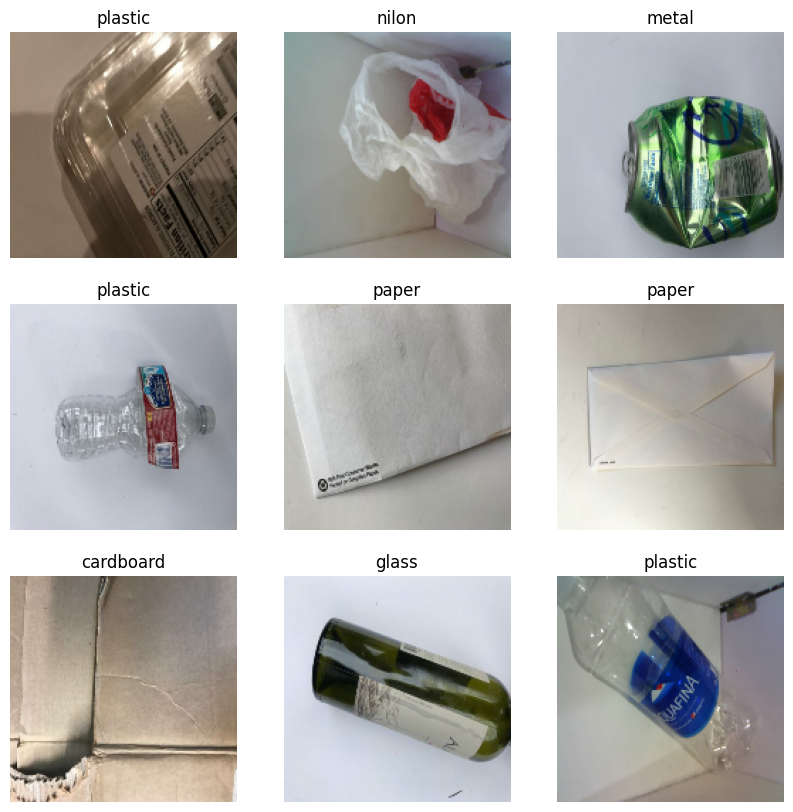

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

num_classes = len(class_names)

(32, 160, 160, 3)
(32,)


In [ ]:
t = train_ds.unbatch()
for x, y in t:
  print(x.shape,y)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNNs from Scratch and steps to improve
___

###1. Plain model:

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
77/77 [==============================] - 215s 3s/step - loss: 1.5909 - accuracy: 0.3729 - val_loss: 1.3285 - val_accuracy: 0.5164
Epoch 2/10
77/77 [==============================] - 1s 17ms/step - loss: 1.2534 - accuracy: 0.5187 - val_loss: 1.2017 - val_accuracy: 0.5461
Epoch 3/10
77/77 [==============================] - 1s 16ms/step - loss: 1.0168 - accuracy: 0.6255 - val_loss: 1.0904 - val_accuracy: 0.6118
Epoch 4/10
77/77 [==============================] - 1s 15ms/step - loss: 0.8151 - accuracy: 0.7010 - val_loss: 1.0213 - val_accuracy: 0.6612
Epoch 5/10
77/77 [==============================] - 1s 17ms/step - loss: 0.6624 - accuracy: 0.7626 - val_loss: 1.0810 - val_accuracy: 0.6480
Epoch 6/10
77/77 [==============================] - 1s 17ms/step - loss: 0.4828 - accuracy: 0.8218 - val_loss: 1.1182 - val_accuracy: 0.6480
Epoch 7/10
77/77 [==============================] - 1s 17ms/step - loss: 0.4233 - accuracy: 0.8538 - val_loss: 1.0147 - val_accuracy: 0.6694
Epoch 8/10
77

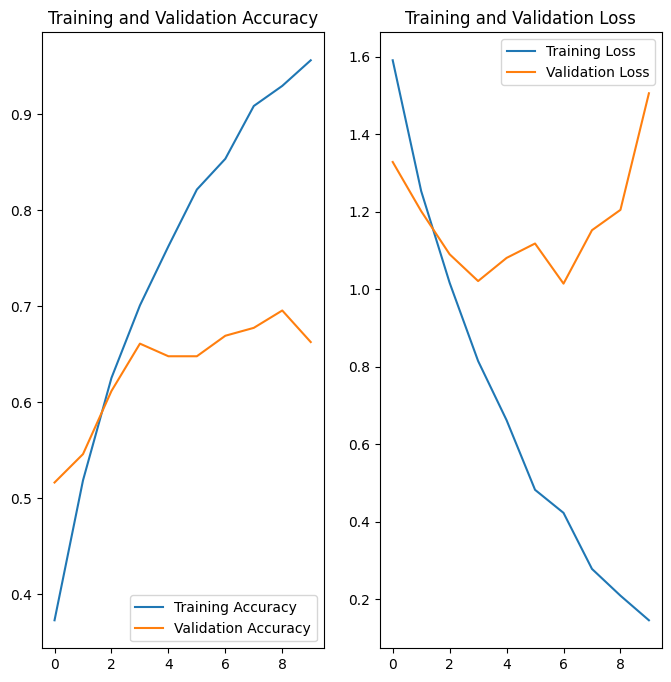

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*The convergence of training accuracy and loss is significant, whearas that of validation ones is almost stable, not changes through epochs, even validation loss tends to increase*

**=> overfit cause of not having much data**

###2. Data Augmentation:

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
  ]
)

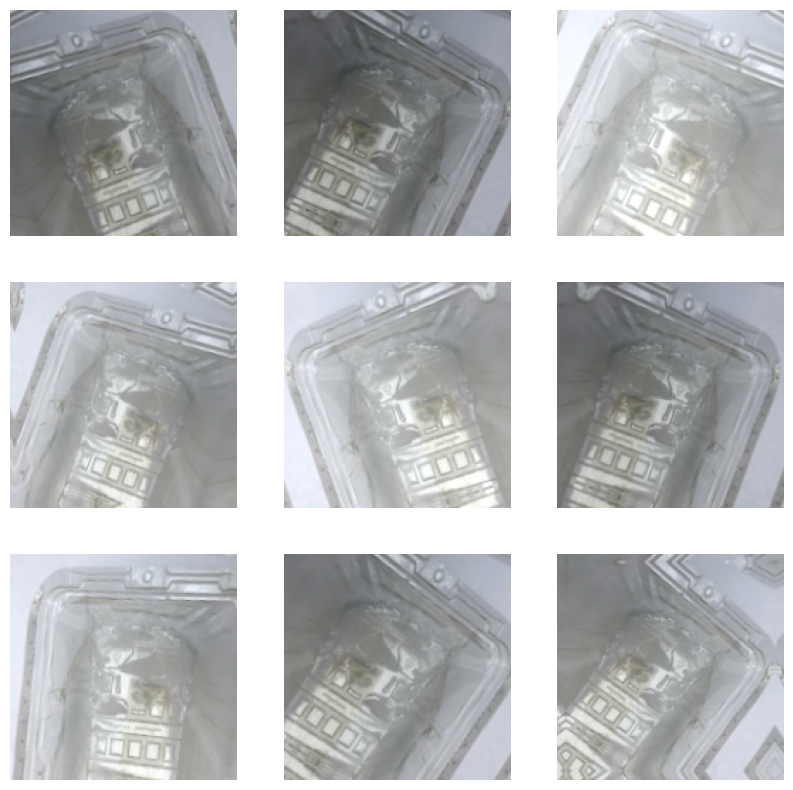

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
callbacks = [
    #EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', start_from_epoch= 34), # mode in {'auto', 'min', 'max'}, patience: sau bao nhiêu epoch không có sự cải thiện thì dừng lại, mode='min': chỉ dừng lại khi loss giảm dần, mode='max': chỉ dừng lại khi loss tăng dần
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='min'), # factor: giảm learning rate bằng factor, patience: số lần không có sự cải thiện nào thì dừng lại, verbose: thông báo
    ModelCheckpoint(filepath="/content/drive/MyDrive/PBL5-Data/training1/aug_only_notES",
                                              save_weights_only=False,
                                              verbose=0)
]

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate = 0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                  

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/100
77/77 [==============================] - ETA: 0s - loss: 1.7206 - accuracy: 0.3179

77/77 [==============================] - 9s 85ms/step - loss: 1.7206 - accuracy: 0.3179 - val_loss: 1.5332 - val_accuracy: 0.3799 - lr: 5.0000e-04
Epoch 2/100
75/77 [============================>.] - ETA: 0s - loss: 1.4905 - accuracy: 0.4243

77/77 [==============================] - 6s 83ms/step - loss: 1.4900 - accuracy: 0.4242 - val_loss: 1.5533 - val_accuracy: 0.3931 - lr: 5.0000e-04
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 1.3970 - accuracy: 0.4690

77/77 [==============================] - 6s 85ms/step - loss: 1.3970 - accuracy: 0.4690 - val_loss: 1.3117 - val_accuracy: 0.5164 - lr: 5.0000e-04
Epoch 4/100
76/77 [============================>.] - ETA: 0s - loss: 1.3211 - accuracy: 0.4998

77/77 [==============================] - 8s 106ms/step - loss: 1.3179 - accuracy: 0.5010 - val_loss: 1.3998 - val_accuracy: 0.4967 - lr: 5.0000e-04
Epoch 5/100
77/77 [==============================] - ETA: 0s - loss: 1.2607 - accuracy: 0.5261

77/77 [==============================] - 7s 95ms/step - loss: 1.2607 - accuracy: 0.5261 - val_loss: 1.2989 - val_accuracy: 0.5214 - lr: 5.0000e-04
Epoch 6/100
77/77 [==============================] - ETA: 0s - loss: 1.1878 - accuracy: 0.5630

77/77 [==============================] - 10s 125ms/step - loss: 1.1878 - accuracy: 0.5630 - val_loss: 1.1893 - val_accuracy: 0.5477 - lr: 5.0000e-04
Epoch 7/100
77/77 [==============================] - ETA: 0s - loss: 1.1518 - accuracy: 0.5680

77/77 [==============================] - 8s 102ms/step - loss: 1.1518 - accuracy: 0.5680 - val_loss: 1.1834 - val_accuracy: 0.5609 - lr: 5.0000e-04
Epoch 8/100
77/77 [==============================] - ETA: 0s - loss: 1.1081 - accuracy: 0.5877

77/77 [==============================] - 9s 113ms/step - loss: 1.1081 - accuracy: 0.5877 - val_loss: 1.1906 - val_accuracy: 0.5740 - lr: 5.0000e-04
Epoch 9/100
77/77 [==============================] - ETA: 0s - loss: 1.0710 - accuracy: 0.6041

77/77 [==============================] - 5s 68ms/step - loss: 1.0710 - accuracy: 0.6041 - val_loss: 1.1758 - val_accuracy: 0.5822 - lr: 5.0000e-04
Epoch 10/100
75/77 [============================>.] - ETA: 0s - loss: 1.0198 - accuracy: 0.6242

77/77 [==============================] - 8s 103ms/step - loss: 1.0191 - accuracy: 0.6242 - val_loss: 1.1518 - val_accuracy: 0.5921 - lr: 5.0000e-04
Epoch 11/100
77/77 [==============================] - ETA: 0s - loss: 1.0188 - accuracy: 0.6209

77/77 [==============================] - 8s 102ms/step - loss: 1.0188 - accuracy: 0.6209 - val_loss: 1.0169 - val_accuracy: 0.6316 - lr: 5.0000e-04
Epoch 12/100
77/77 [==============================] - ETA: 0s - loss: 0.9559 - accuracy: 0.6468

77/77 [==============================] - 7s 95ms/step - loss: 0.9559 - accuracy: 0.6468 - val_loss: 1.0732 - val_accuracy: 0.6283 - lr: 5.0000e-04
Epoch 13/100
76/77 [============================>.] - ETA: 0s - loss: 0.9018 - accuracy: 0.6712

77/77 [==============================] - 6s 80ms/step - loss: 0.9015 - accuracy: 0.6690 - val_loss: 1.2322 - val_accuracy: 0.5921 - lr: 5.0000e-04
Epoch 14/100
77/77 [==============================] - ETA: 0s - loss: 0.9140 - accuracy: 0.6608

77/77 [==============================] - 10s 130ms/step - loss: 0.9140 - accuracy: 0.6608 - val_loss: 1.0580 - val_accuracy: 0.6382 - lr: 5.0000e-04
Epoch 15/100
75/77 [============================>.] - ETA: 0s - loss: 0.8534 - accuracy: 0.6984

77/77 [==============================] - 10s 131ms/step - loss: 0.8582 - accuracy: 0.6965 - val_loss: 1.0877 - val_accuracy: 0.6036 - lr: 5.0000e-04
Epoch 16/100
77/77 [==============================] - ETA: 0s - loss: 0.8362 - accuracy: 0.6908
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.


77/77 [==============================] - 6s 80ms/step - loss: 0.8362 - accuracy: 0.6908 - val_loss: 1.1342 - val_accuracy: 0.6283 - lr: 5.0000e-04
Epoch 17/100
75/77 [============================>.] - ETA: 0s - loss: 0.8014 - accuracy: 0.7136

77/77 [==============================] - 8s 105ms/step - loss: 0.7973 - accuracy: 0.7146 - val_loss: 1.1292 - val_accuracy: 0.6447 - lr: 4.0000e-04
Epoch 18/100
76/77 [============================>.] - ETA: 0s - loss: 0.7723 - accuracy: 0.7129

77/77 [==============================] - 8s 108ms/step - loss: 0.7677 - accuracy: 0.7154 - val_loss: 1.0394 - val_accuracy: 0.6414 - lr: 4.0000e-04
Epoch 19/100
76/77 [============================>.] - ETA: 0s - loss: 0.7337 - accuracy: 0.7391

77/77 [==============================] - 5s 66ms/step - loss: 0.7351 - accuracy: 0.7372 - val_loss: 0.9370 - val_accuracy: 0.6859 - lr: 4.0000e-04
Epoch 20/100
75/77 [============================>.] - ETA: 0s - loss: 0.7235 - accuracy: 0.7296

77/77 [==============================] - 7s 95ms/step - loss: 0.7218 - accuracy: 0.7310 - val_loss: 1.0512 - val_accuracy: 0.6727 - lr: 4.0000e-04
Epoch 21/100
77/77 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.7425

77/77 [==============================] - 6s 79ms/step - loss: 0.6977 - accuracy: 0.7425 - val_loss: 1.0138 - val_accuracy: 0.6612 - lr: 4.0000e-04
Epoch 22/100
75/77 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.7583

77/77 [==============================] - 9s 102ms/step - loss: 0.6572 - accuracy: 0.7589 - val_loss: 1.0647 - val_accuracy: 0.6711 - lr: 4.0000e-04
Epoch 23/100
77/77 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.7639

77/77 [==============================] - 8s 105ms/step - loss: 0.6405 - accuracy: 0.7639 - val_loss: 1.0419 - val_accuracy: 0.6826 - lr: 4.0000e-04
Epoch 24/100
77/77 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.7589
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00032000001519918444.


77/77 [==============================] - 8s 93ms/step - loss: 0.6478 - accuracy: 0.7589 - val_loss: 0.9913 - val_accuracy: 0.6743 - lr: 4.0000e-04
Epoch 25/100
75/77 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.7777

77/77 [==============================] - 7s 92ms/step - loss: 0.6093 - accuracy: 0.7795 - val_loss: 1.0673 - val_accuracy: 0.6645 - lr: 3.2000e-04
Epoch 26/100
77/77 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.7762

77/77 [==============================] - 7s 94ms/step - loss: 0.6103 - accuracy: 0.7762 - val_loss: 0.9329 - val_accuracy: 0.6974 - lr: 3.2000e-04
Epoch 27/100
77/77 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.7795

77/77 [==============================] - 6s 74ms/step - loss: 0.5921 - accuracy: 0.7795 - val_loss: 0.9924 - val_accuracy: 0.6875 - lr: 3.2000e-04
Epoch 28/100
76/77 [============================>.] - ETA: 0s - loss: 0.5458 - accuracy: 0.8019

77/77 [==============================] - 7s 95ms/step - loss: 0.5466 - accuracy: 0.8016 - val_loss: 0.9459 - val_accuracy: 0.7105 - lr: 3.2000e-04
Epoch 29/100
75/77 [============================>.] - ETA: 0s - loss: 0.5520 - accuracy: 0.7912

77/77 [==============================] - 8s 109ms/step - loss: 0.5552 - accuracy: 0.7893 - val_loss: 0.9590 - val_accuracy: 0.6875 - lr: 3.2000e-04
Epoch 30/100
76/77 [============================>.] - ETA: 0s - loss: 0.5437 - accuracy: 0.8002

77/77 [==============================] - 10s 126ms/step - loss: 0.5412 - accuracy: 0.8008 - val_loss: 1.0581 - val_accuracy: 0.6859 - lr: 3.2000e-04
Epoch 31/100
76/77 [============================>.] - ETA: 0s - loss: 0.5241 - accuracy: 0.8048
Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002560000168159604.


77/77 [==============================] - 9s 119ms/step - loss: 0.5231 - accuracy: 0.8049 - val_loss: 0.9363 - val_accuracy: 0.7072 - lr: 3.2000e-04
Epoch 32/100
76/77 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.8119

77/77 [==============================] - 7s 92ms/step - loss: 0.5010 - accuracy: 0.8111 - val_loss: 0.9046 - val_accuracy: 0.7023 - lr: 2.5600e-04
Epoch 33/100
75/77 [============================>.] - ETA: 0s - loss: 0.4852 - accuracy: 0.8279

77/77 [==============================] - 8s 105ms/step - loss: 0.4800 - accuracy: 0.8308 - val_loss: 0.9962 - val_accuracy: 0.6891 - lr: 2.5600e-04
Epoch 34/100
76/77 [============================>.] - ETA: 0s - loss: 0.4721 - accuracy: 0.8240

77/77 [==============================] - 7s 87ms/step - loss: 0.4719 - accuracy: 0.8242 - val_loss: 1.0426 - val_accuracy: 0.6793 - lr: 2.5600e-04
Epoch 35/100
75/77 [============================>.] - ETA: 0s - loss: 0.4585 - accuracy: 0.8229

77/77 [==============================] - 7s 86ms/step - loss: 0.4552 - accuracy: 0.8255 - val_loss: 0.9186 - val_accuracy: 0.7007 - lr: 2.5600e-04
Epoch 36/100
74/77 [===========================>..] - ETA: 0s - loss: 0.4569 - accuracy: 0.8341

77/77 [==============================] - 6s 84ms/step - loss: 0.4595 - accuracy: 0.8324 - val_loss: 0.9881 - val_accuracy: 0.6924 - lr: 2.5600e-04
Epoch 37/100
75/77 [============================>.] - ETA: 0s - loss: 0.4511 - accuracy: 0.8368
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.00020480002276599408.


77/77 [==============================] - 11s 141ms/step - loss: 0.4489 - accuracy: 0.8374 - val_loss: 0.9480 - val_accuracy: 0.6974 - lr: 2.5600e-04
Epoch 38/100
75/77 [============================>.] - ETA: 0s - loss: 0.4148 - accuracy: 0.8473

77/77 [==============================] - 10s 130ms/step - loss: 0.4143 - accuracy: 0.8464 - val_loss: 0.9692 - val_accuracy: 0.7056 - lr: 2.0480e-04
Epoch 39/100
75/77 [============================>.] - ETA: 0s - loss: 0.4053 - accuracy: 0.8541

77/77 [==============================] - 5s 66ms/step - loss: 0.4004 - accuracy: 0.8567 - val_loss: 0.9745 - val_accuracy: 0.6891 - lr: 2.0480e-04
Epoch 40/100
77/77 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.8493

77/77 [==============================] - 7s 93ms/step - loss: 0.4088 - accuracy: 0.8493 - val_loss: 0.8976 - val_accuracy: 0.7138 - lr: 2.0480e-04
Epoch 41/100
76/77 [============================>.] - ETA: 0s - loss: 0.3945 - accuracy: 0.8543

77/77 [==============================] - 7s 91ms/step - loss: 0.3931 - accuracy: 0.8550 - val_loss: 0.9411 - val_accuracy: 0.7138 - lr: 2.0480e-04
Epoch 42/100
75/77 [============================>.] - ETA: 0s - loss: 0.4045 - accuracy: 0.8604

77/77 [==============================] - 7s 91ms/step - loss: 0.4052 - accuracy: 0.8604 - val_loss: 0.9291 - val_accuracy: 0.6974 - lr: 2.0480e-04
Epoch 43/100
76/77 [============================>.] - ETA: 0s - loss: 0.4003 - accuracy: 0.8573

77/77 [==============================] - 7s 97ms/step - loss: 0.4003 - accuracy: 0.8571 - val_loss: 1.0319 - val_accuracy: 0.6891 - lr: 2.0480e-04
Epoch 44/100
75/77 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8718

77/77 [==============================] - 6s 77ms/step - loss: 0.3526 - accuracy: 0.8731 - val_loss: 1.0040 - val_accuracy: 0.7171 - lr: 2.0480e-04
Epoch 45/100
75/77 [============================>.] - ETA: 0s - loss: 0.3574 - accuracy: 0.8633
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.00016384001355618238.


77/77 [==============================] - 7s 95ms/step - loss: 0.3604 - accuracy: 0.8628 - val_loss: 0.9774 - val_accuracy: 0.7039 - lr: 2.0480e-04
Epoch 46/100
75/77 [============================>.] - ETA: 0s - loss: 0.3687 - accuracy: 0.8705

77/77 [==============================] - 7s 91ms/step - loss: 0.3682 - accuracy: 0.8698 - val_loss: 0.9726 - val_accuracy: 0.7155 - lr: 1.6384e-04
Epoch 47/100
77/77 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8735

77/77 [==============================] - 10s 129ms/step - loss: 0.3487 - accuracy: 0.8735 - val_loss: 1.0987 - val_accuracy: 0.6793 - lr: 1.6384e-04
Epoch 48/100
75/77 [============================>.] - ETA: 0s - loss: 0.3550 - accuracy: 0.8680

77/77 [==============================] - 10s 129ms/step - loss: 0.3529 - accuracy: 0.8694 - val_loss: 0.9258 - val_accuracy: 0.7237 - lr: 1.6384e-04
Epoch 49/100
75/77 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8882

77/77 [==============================] - 7s 88ms/step - loss: 0.3157 - accuracy: 0.8895 - val_loss: 0.9487 - val_accuracy: 0.7352 - lr: 1.6384e-04
Epoch 50/100
77/77 [==============================] - ETA: 0s - loss: 0.3329 - accuracy: 0.8805
Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001310720108449459.


77/77 [==============================] - 8s 101ms/step - loss: 0.3329 - accuracy: 0.8805 - val_loss: 1.0011 - val_accuracy: 0.7286 - lr: 1.6384e-04
Epoch 51/100
75/77 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.8929

77/77 [==============================] - 7s 97ms/step - loss: 0.3112 - accuracy: 0.8936 - val_loss: 0.9518 - val_accuracy: 0.7105 - lr: 1.3107e-04
Epoch 52/100
75/77 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8929

77/77 [==============================] - 9s 115ms/step - loss: 0.3089 - accuracy: 0.8928 - val_loss: 1.0392 - val_accuracy: 0.7023 - lr: 1.3107e-04
Epoch 53/100
76/77 [============================>.] - ETA: 0s - loss: 0.3328 - accuracy: 0.8851

77/77 [==============================] - 7s 92ms/step - loss: 0.3330 - accuracy: 0.8858 - val_loss: 0.9576 - val_accuracy: 0.7336 - lr: 1.3107e-04
Epoch 54/100
76/77 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8851

77/77 [==============================] - 6s 78ms/step - loss: 0.3209 - accuracy: 0.8854 - val_loss: 0.9446 - val_accuracy: 0.7237 - lr: 1.3107e-04
Epoch 55/100
77/77 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8969
Epoch 55: ReduceLROnPlateau reducing learning rate to 0.00010485760867595673.


77/77 [==============================] - 9s 115ms/step - loss: 0.3014 - accuracy: 0.8969 - val_loss: 1.0316 - val_accuracy: 0.7138 - lr: 1.3107e-04
Epoch 56/100
77/77 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8986

77/77 [==============================] - 5s 66ms/step - loss: 0.2872 - accuracy: 0.8986 - val_loss: 0.9570 - val_accuracy: 0.7253 - lr: 1.0486e-04
Epoch 57/100
77/77 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9129

77/77 [==============================] - 7s 93ms/step - loss: 0.2695 - accuracy: 0.9129 - val_loss: 0.9281 - val_accuracy: 0.7303 - lr: 1.0486e-04
Epoch 58/100
75/77 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.8962

77/77 [==============================] - 6s 77ms/step - loss: 0.2892 - accuracy: 0.8953 - val_loss: 0.9741 - val_accuracy: 0.7303 - lr: 1.0486e-04
Epoch 59/100
75/77 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.9051

77/77 [==============================] - 9s 120ms/step - loss: 0.2812 - accuracy: 0.9060 - val_loss: 0.9882 - val_accuracy: 0.7319 - lr: 1.0486e-04
Epoch 60/100
76/77 [============================>.] - ETA: 0s - loss: 0.2869 - accuracy: 0.9014

77/77 [==============================] - 7s 97ms/step - loss: 0.2897 - accuracy: 0.9010 - val_loss: 0.8795 - val_accuracy: 0.7385 - lr: 1.0486e-04
Epoch 61/100
76/77 [============================>.] - ETA: 0s - loss: 0.2837 - accuracy: 0.9047

77/77 [==============================] - 7s 90ms/step - loss: 0.2840 - accuracy: 0.9043 - val_loss: 0.9557 - val_accuracy: 0.7204 - lr: 1.0486e-04
Epoch 62/100
76/77 [============================>.] - ETA: 0s - loss: 0.2837 - accuracy: 0.9039

77/77 [==============================] - 8s 105ms/step - loss: 0.2816 - accuracy: 0.9051 - val_loss: 1.0337 - val_accuracy: 0.7171 - lr: 1.0486e-04
Epoch 63/100
76/77 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.9126

77/77 [==============================] - 6s 78ms/step - loss: 0.2642 - accuracy: 0.9129 - val_loss: 0.9141 - val_accuracy: 0.7500 - lr: 1.0486e-04
Epoch 64/100
76/77 [============================>.] - ETA: 0s - loss: 0.2579 - accuracy: 0.9076

77/77 [==============================] - 7s 92ms/step - loss: 0.2578 - accuracy: 0.9076 - val_loss: 0.9409 - val_accuracy: 0.7434 - lr: 1.0486e-04
Epoch 65/100
76/77 [============================>.] - ETA: 0s - loss: 0.2658 - accuracy: 0.9084
Epoch 65: ReduceLROnPlateau reducing learning rate to 8.388608694076538e-05.


77/77 [==============================] - 6s 78ms/step - loss: 0.2632 - accuracy: 0.9097 - val_loss: 1.0088 - val_accuracy: 0.7336 - lr: 1.0486e-04
Epoch 66/100
76/77 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.9118

77/77 [==============================] - 10s 127ms/step - loss: 0.2663 - accuracy: 0.9121 - val_loss: 0.9837 - val_accuracy: 0.7171 - lr: 8.3886e-05
Epoch 67/100
74/77 [===========================>..] - ETA: 0s - loss: 0.2489 - accuracy: 0.9210

77/77 [==============================] - 6s 79ms/step - loss: 0.2475 - accuracy: 0.9216 - val_loss: 0.9411 - val_accuracy: 0.7418 - lr: 8.3886e-05
Epoch 68/100
75/77 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.9093

77/77 [==============================] - 8s 106ms/step - loss: 0.2592 - accuracy: 0.9097 - val_loss: 0.9626 - val_accuracy: 0.7253 - lr: 8.3886e-05
Epoch 69/100
77/77 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9187

77/77 [==============================] - 6s 82ms/step - loss: 0.2343 - accuracy: 0.9187 - val_loss: 1.0434 - val_accuracy: 0.7220 - lr: 8.3886e-05
Epoch 70/100
77/77 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9179
Epoch 70: ReduceLROnPlateau reducing learning rate to 6.710886955261231e-05.


77/77 [==============================] - 9s 122ms/step - loss: 0.2310 - accuracy: 0.9179 - val_loss: 0.9694 - val_accuracy: 0.7368 - lr: 8.3886e-05
Epoch 71/100
76/77 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9222

77/77 [==============================] - 9s 122ms/step - loss: 0.2265 - accuracy: 0.9220 - val_loss: 0.9681 - val_accuracy: 0.7319 - lr: 6.7109e-05
Epoch 72/100
75/77 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9182

77/77 [==============================] - 8s 108ms/step - loss: 0.2340 - accuracy: 0.9187 - val_loss: 1.0241 - val_accuracy: 0.7237 - lr: 6.7109e-05
Epoch 73/100
75/77 [============================>.] - ETA: 0s - loss: 0.2398 - accuracy: 0.9199

77/77 [==============================] - 9s 101ms/step - loss: 0.2394 - accuracy: 0.9207 - val_loss: 1.0656 - val_accuracy: 0.7237 - lr: 6.7109e-05
Epoch 74/100
77/77 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9240

77/77 [==============================] - 9s 119ms/step - loss: 0.2286 - accuracy: 0.9240 - val_loss: 1.0285 - val_accuracy: 0.7237 - lr: 6.7109e-05
Epoch 75/100
75/77 [============================>.] - ETA: 0s - loss: 0.2337 - accuracy: 0.9173
Epoch 75: ReduceLROnPlateau reducing learning rate to 5.3687096806243065e-05.


77/77 [==============================] - 8s 103ms/step - loss: 0.2344 - accuracy: 0.9179 - val_loss: 1.0470 - val_accuracy: 0.7237 - lr: 6.7109e-05
Epoch 76/100
76/77 [============================>.] - ETA: 0s - loss: 0.2314 - accuracy: 0.9213

77/77 [==============================] - 7s 97ms/step - loss: 0.2326 - accuracy: 0.9207 - val_loss: 1.0239 - val_accuracy: 0.7286 - lr: 5.3687e-05
Epoch 77/100
75/77 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9237

77/77 [==============================] - 9s 115ms/step - loss: 0.2210 - accuracy: 0.9220 - val_loss: 1.0029 - val_accuracy: 0.7286 - lr: 5.3687e-05
Epoch 78/100
77/77 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9277

77/77 [==============================] - 7s 93ms/step - loss: 0.2262 - accuracy: 0.9277 - val_loss: 0.9693 - val_accuracy: 0.7303 - lr: 5.3687e-05
Epoch 79/100
75/77 [============================>.] - ETA: 0s - loss: 0.2204 - accuracy: 0.9211

77/77 [==============================] - 7s 90ms/step - loss: 0.2210 - accuracy: 0.9211 - val_loss: 0.9816 - val_accuracy: 0.7303 - lr: 5.3687e-05
Epoch 80/100
76/77 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9259
Epoch 80: ReduceLROnPlateau reducing learning rate to 4.2949678027071064e-05.


77/77 [==============================] - 8s 105ms/step - loss: 0.2177 - accuracy: 0.9265 - val_loss: 1.0650 - val_accuracy: 0.7220 - lr: 5.3687e-05
Epoch 81/100
75/77 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9241

77/77 [==============================] - 10s 123ms/step - loss: 0.2300 - accuracy: 0.9248 - val_loss: 0.9657 - val_accuracy: 0.7401 - lr: 4.2950e-05
Epoch 82/100
77/77 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9302

77/77 [==============================] - 6s 80ms/step - loss: 0.2182 - accuracy: 0.9302 - val_loss: 1.0075 - val_accuracy: 0.7253 - lr: 4.2950e-05
Epoch 83/100
76/77 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9305

77/77 [==============================] - 9s 122ms/step - loss: 0.2193 - accuracy: 0.9306 - val_loss: 0.9928 - val_accuracy: 0.7270 - lr: 4.2950e-05
Epoch 84/100
76/77 [============================>.] - ETA: 0s - loss: 0.2033 - accuracy: 0.9342

77/77 [==============================] - 10s 129ms/step - loss: 0.2023 - accuracy: 0.9347 - val_loss: 1.0685 - val_accuracy: 0.7270 - lr: 4.2950e-05
Epoch 85/100
77/77 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9339
Epoch 85: ReduceLROnPlateau reducing learning rate to 3.435974358581007e-05.


77/77 [==============================] - 8s 104ms/step - loss: 0.2052 - accuracy: 0.9339 - val_loss: 1.0307 - val_accuracy: 0.7253 - lr: 4.2950e-05
Epoch 86/100
77/77 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9302

77/77 [==============================] - 7s 96ms/step - loss: 0.2033 - accuracy: 0.9302 - val_loss: 1.0522 - val_accuracy: 0.7319 - lr: 3.4360e-05
Epoch 87/100
76/77 [============================>.] - ETA: 0s - loss: 0.1983 - accuracy: 0.9384

77/77 [==============================] - 8s 108ms/step - loss: 0.1986 - accuracy: 0.9384 - val_loss: 0.9702 - val_accuracy: 0.7303 - lr: 3.4360e-05
Epoch 88/100
75/77 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9350

77/77 [==============================] - 7s 88ms/step - loss: 0.1996 - accuracy: 0.9363 - val_loss: 1.0592 - val_accuracy: 0.7253 - lr: 3.4360e-05
Epoch 89/100
76/77 [============================>.] - ETA: 0s - loss: 0.2052 - accuracy: 0.9318

77/77 [==============================] - 9s 117ms/step - loss: 0.2048 - accuracy: 0.9314 - val_loss: 0.9992 - val_accuracy: 0.7352 - lr: 3.4360e-05
Epoch 90/100
77/77 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9368
Epoch 90: ReduceLROnPlateau reducing learning rate to 2.7487793704494835e-05.


77/77 [==============================] - 10s 137ms/step - loss: 0.1986 - accuracy: 0.9368 - val_loss: 1.0352 - val_accuracy: 0.7385 - lr: 3.4360e-05
Epoch 91/100
76/77 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9301

77/77 [==============================] - 7s 91ms/step - loss: 0.2133 - accuracy: 0.9310 - val_loss: 1.0258 - val_accuracy: 0.7270 - lr: 2.7488e-05
Epoch 92/100
75/77 [============================>.] - ETA: 0s - loss: 0.1969 - accuracy: 0.9380

77/77 [==============================] - 7s 98ms/step - loss: 0.1966 - accuracy: 0.9368 - val_loss: 1.0386 - val_accuracy: 0.7319 - lr: 2.7488e-05
Epoch 93/100
76/77 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9422

77/77 [==============================] - 7s 91ms/step - loss: 0.1900 - accuracy: 0.9409 - val_loss: 0.9727 - val_accuracy: 0.7434 - lr: 2.7488e-05
Epoch 94/100
77/77 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9425

77/77 [==============================] - 9s 121ms/step - loss: 0.1905 - accuracy: 0.9425 - val_loss: 1.0122 - val_accuracy: 0.7303 - lr: 2.7488e-05
Epoch 95/100
76/77 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9330
Epoch 95: ReduceLROnPlateau reducing learning rate to 2.199023438151926e-05.


77/77 [==============================] - 6s 77ms/step - loss: 0.1990 - accuracy: 0.9331 - val_loss: 1.0618 - val_accuracy: 0.7336 - lr: 2.7488e-05
Epoch 96/100
77/77 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9396

77/77 [==============================] - 7s 88ms/step - loss: 0.1899 - accuracy: 0.9396 - val_loss: 1.0092 - val_accuracy: 0.7303 - lr: 2.1990e-05
Epoch 97/100
76/77 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy: 0.9372

77/77 [==============================] - 8s 100ms/step - loss: 0.1893 - accuracy: 0.9376 - val_loss: 1.0631 - val_accuracy: 0.7253 - lr: 2.1990e-05
Epoch 98/100
77/77 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9499

77/77 [==============================] - 6s 66ms/step - loss: 0.1668 - accuracy: 0.9499 - val_loss: 1.0133 - val_accuracy: 0.7352 - lr: 2.1990e-05
Epoch 99/100
77/77 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9355

77/77 [==============================] - 9s 121ms/step - loss: 0.1916 - accuracy: 0.9355 - val_loss: 1.0268 - val_accuracy: 0.7319 - lr: 2.1990e-05
Epoch 100/100
76/77 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9392
Epoch 100: ReduceLROnPlateau reducing learning rate to 1.7592187214177104e-05.


77/77 [==============================] - 7s 90ms/step - loss: 0.1954 - accuracy: 0.9396 - val_loss: 1.0622 - val_accuracy: 0.7319 - lr: 2.1990e-05


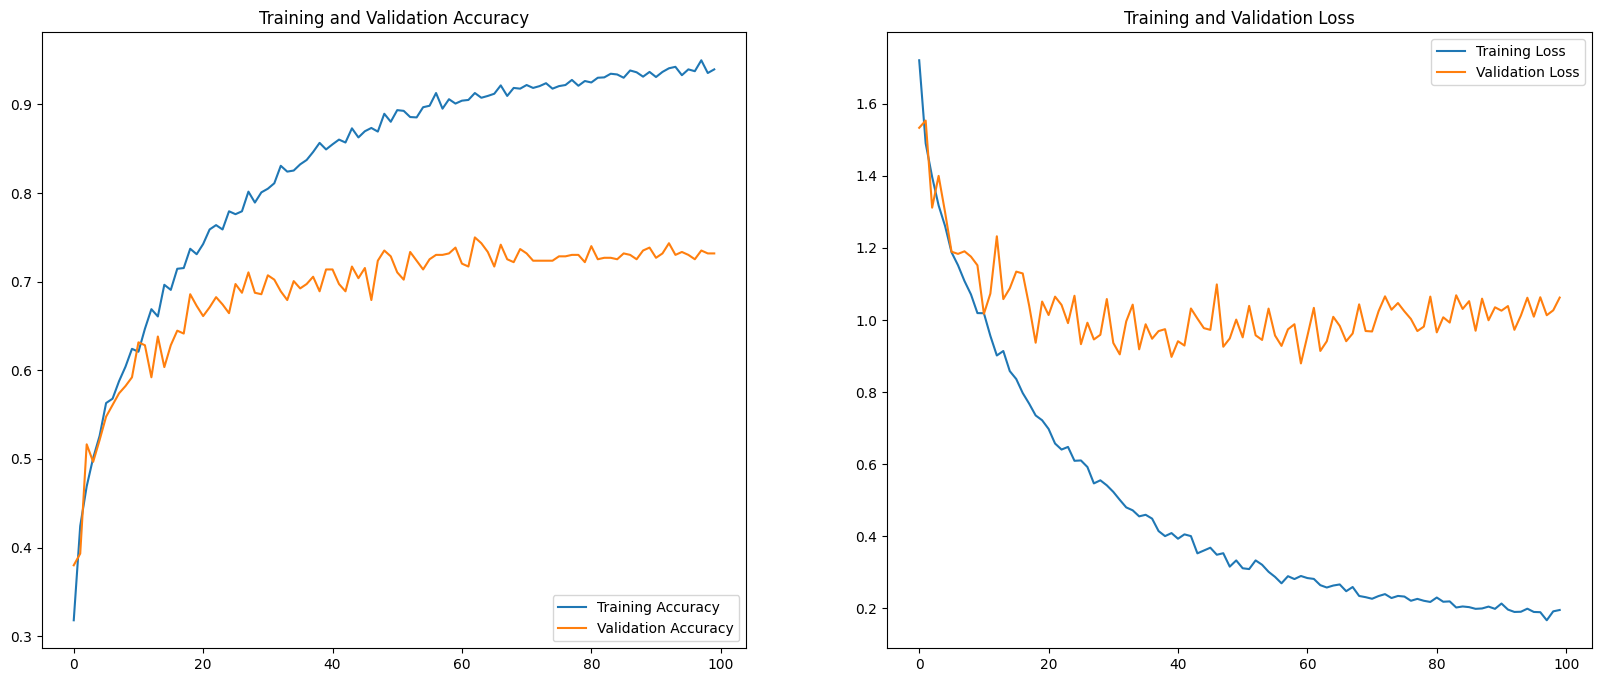

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Accuracy on training and validation is more improved (>72%). However, gap betwwen them is still wide and validation loss still tends to increase*

**=> overfit or model maybe more complex compare to training data**

###3. Augmentation + Dropout:

In [ ]:
hist_df_new = pd.DataFrame(history.history)

In [ ]:
hist_csv_file = '/content/drive/MyDrive/PBL5-Data/history/hist_aug_only_notES'
with open(hist_csv_file, mode='w') as f:
    hist_df_new.to_csv(f)

In [ ]:
hist_df = pd.read_csv("/content/drive/MyDrive/PBL5-Data/history/hist_aug_only") 

In [ ]:
hist_df = pd.concat([hist_df,pd.DataFrame(history.history)], axis = 0)

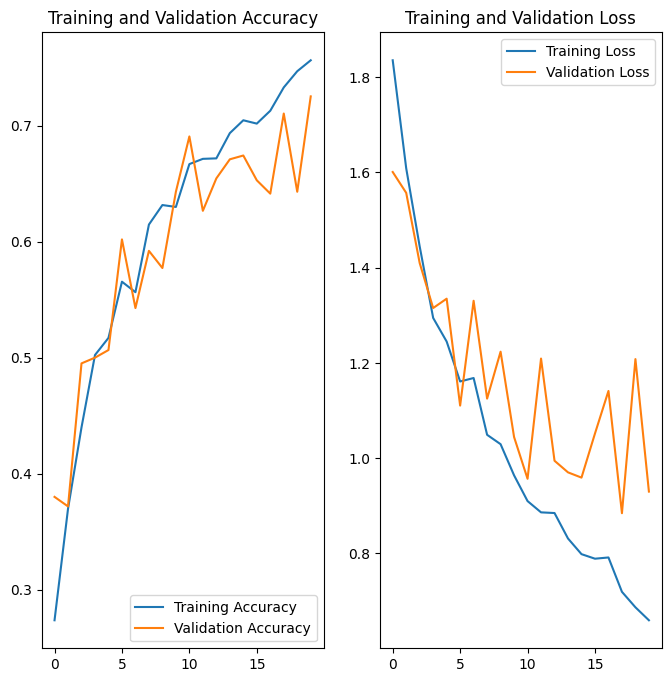

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*The model is more fit. However, accuray is not high enough and more fluctuate through training process*

**=> dropout has removed learning ability of model and number of training data, epochs is not high enough, so it is not stable through train**

###4. Augmentation + Dropout + Batch Normallize

In [ ]:
def augment(image_label, seed):
  image, label = image_label
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [ ]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [ ]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

In [ ]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_ds, (counter, counter)))

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', name = 'conv_1'),
  layers.MaxPooling2D((2,2), strides = 2),
  layers.BatchNormalization(name = 'bn_conv_1'),
  layers.Conv2D(32, 3, padding='same', activation='relu', name = 'conv_2'),
  layers.MaxPooling2D((2,2), strides = 2),
  layers.BatchNormalization(name = 'bn_conv_2'),
  layers.Conv2D(64, 3, padding='same', activation='relu', name = 'conv_3'),
  layers.MaxPooling2D((2,2), strides = 2),
  layers.BatchNormalization(name = 'bn_conv_3'),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu', name = 'fc1'),
  layers.Dropout(0.1),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', start_from_epoch= 34), # mode in {'auto', 'min', 'max'}, patience: sau bao nhiêu epoch không có sự cải thiện thì dừng lại, mode='min': chỉ dừng lại khi loss giảm dần, mode='max': chỉ dừng lại khi loss tăng dần
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='min'), # factor: giảm learning rate bằng factor, patience: số lần không có sự cải thiện nào thì dừng lại, verbose: thông báo
    ModelCheckpoint(filepath="/content/drive/MyDrive/PBL5-Data/training1/checkpoint2",
                                              save_weights_only=False,
                                              verbose=0)
]

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate = 0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/PBL5-Data/training1/checkpoint2")

In [ ]:
train_ds 

<BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv_1 (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 bn_conv_1 (BatchNormalizati  (None, 80, 80, 16)       64        
 on)                                                             
                                                                 
 conv_2 (Conv2D)             (None, 80, 80, 32)       

In [ ]:
epochs =100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/100
76/77 [============================>.] - ETA: 0s - loss: 2.1132 - accuracy: 0.4007

77/77 [==============================] - 10s 72ms/step - loss: 2.1015 - accuracy: 0.4029 - val_loss: 2.5919 - val_accuracy: 0.0247 - lr: 5.0000e-04
Epoch 2/100
76/77 [============================>.] - ETA: 0s - loss: 1.4586 - accuracy: 0.4673

77/77 [==============================] - 5s 65ms/step - loss: 1.4531 - accuracy: 0.4694 - val_loss: 3.1659 - val_accuracy: 0.0378 - lr: 5.0000e-04
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 1.3000 - accuracy: 0.5359

77/77 [==============================] - 6s 79ms/step - loss: 1.3000 - accuracy: 0.5359 - val_loss: 2.5057 - val_accuracy: 0.2072 - lr: 5.0000e-04
Epoch 4/100
75/77 [============================>.] - ETA: 0s - loss: 1.3028 - accuracy: 0.5251

77/77 [==============================] - 5s 66ms/step - loss: 1.2992 - accuracy: 0.5265 - val_loss: 1.8086 - val_accuracy: 0.3273 - lr: 5.0000e-04
Epoch 5/100
75/77 [============================>.] - ETA: 0s - loss: 1.1878 - accuracy: 0.5593

77/77 [==============================] - 7s 90ms/step - loss: 1.1856 - accuracy: 0.5602 - val_loss: 1.9170 - val_accuracy: 0.3799 - lr: 5.0000e-04
Epoch 6/100
75/77 [============================>.] - ETA: 0s - loss: 1.1944 - accuracy: 0.5643

77/77 [==============================] - 5s 70ms/step - loss: 1.1900 - accuracy: 0.5651 - val_loss: 1.2652 - val_accuracy: 0.5082 - lr: 5.0000e-04
Epoch 7/100
77/77 [==============================] - ETA: 0s - loss: 1.1130 - accuracy: 0.5959

77/77 [==============================] - 6s 73ms/step - loss: 1.1130 - accuracy: 0.5959 - val_loss: 1.1240 - val_accuracy: 0.5987 - lr: 5.0000e-04
Epoch 8/100
75/77 [============================>.] - ETA: 0s - loss: 1.0921 - accuracy: 0.6061

77/77 [==============================] - 8s 103ms/step - loss: 1.0941 - accuracy: 0.6045 - val_loss: 1.1717 - val_accuracy: 0.5987 - lr: 5.0000e-04
Epoch 9/100
75/77 [============================>.] - ETA: 0s - loss: 1.0452 - accuracy: 0.6217

77/77 [==============================] - 5s 71ms/step - loss: 1.0379 - accuracy: 0.6246 - val_loss: 1.4264 - val_accuracy: 0.5148 - lr: 5.0000e-04
Epoch 10/100
77/77 [==============================] - ETA: 0s - loss: 1.0238 - accuracy: 0.6292

77/77 [==============================] - 5s 71ms/step - loss: 1.0238 - accuracy: 0.6292 - val_loss: 1.1089 - val_accuracy: 0.6069 - lr: 5.0000e-04
Epoch 11/100
76/77 [============================>.] - ETA: 0s - loss: 0.9612 - accuracy: 0.6446

77/77 [==============================] - 6s 80ms/step - loss: 0.9595 - accuracy: 0.6452 - val_loss: 1.2012 - val_accuracy: 0.6102 - lr: 5.0000e-04
Epoch 12/100
76/77 [============================>.] - ETA: 0s - loss: 0.9474 - accuracy: 0.6687

77/77 [==============================] - 6s 77ms/step - loss: 0.9499 - accuracy: 0.6682 - val_loss: 1.3062 - val_accuracy: 0.6299 - lr: 5.0000e-04
Epoch 13/100
75/77 [============================>.] - ETA: 0s - loss: 0.8939 - accuracy: 0.6679

77/77 [==============================] - 6s 72ms/step - loss: 0.8922 - accuracy: 0.6686 - val_loss: 1.3093 - val_accuracy: 0.5938 - lr: 5.0000e-04
Epoch 14/100
75/77 [============================>.] - ETA: 0s - loss: 0.9226 - accuracy: 0.6575

77/77 [==============================] - 6s 74ms/step - loss: 0.9169 - accuracy: 0.6575 - val_loss: 1.1158 - val_accuracy: 0.6431 - lr: 5.0000e-04
Epoch 15/100
77/77 [==============================] - ETA: 0s - loss: 0.8546 - accuracy: 0.6817
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.


77/77 [==============================] - 6s 81ms/step - loss: 0.8546 - accuracy: 0.6817 - val_loss: 1.4314 - val_accuracy: 0.5954 - lr: 5.0000e-04
Epoch 16/100
77/77 [==============================] - ETA: 0s - loss: 0.8445 - accuracy: 0.6830

77/77 [==============================] - 6s 80ms/step - loss: 0.8445 - accuracy: 0.6830 - val_loss: 1.2747 - val_accuracy: 0.6020 - lr: 4.0000e-04
Epoch 17/100
77/77 [==============================] - ETA: 0s - loss: 0.7938 - accuracy: 0.7047

77/77 [==============================] - 5s 66ms/step - loss: 0.7938 - accuracy: 0.7047 - val_loss: 1.2531 - val_accuracy: 0.5888 - lr: 4.0000e-04
Epoch 18/100
77/77 [==============================] - ETA: 0s - loss: 0.7729 - accuracy: 0.7105

77/77 [==============================] - 7s 88ms/step - loss: 0.7729 - accuracy: 0.7105 - val_loss: 1.1917 - val_accuracy: 0.6118 - lr: 4.0000e-04
Epoch 19/100
76/77 [============================>.] - ETA: 0s - loss: 0.7290 - accuracy: 0.7174

77/77 [==============================] - 5s 67ms/step - loss: 0.7328 - accuracy: 0.7170 - val_loss: 1.4416 - val_accuracy: 0.5789 - lr: 4.0000e-04
Epoch 20/100
75/77 [============================>.] - ETA: 0s - loss: 0.7695 - accuracy: 0.7208
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00032000001519918444.


77/77 [==============================] - 6s 82ms/step - loss: 0.7706 - accuracy: 0.7199 - val_loss: 1.4718 - val_accuracy: 0.5674 - lr: 4.0000e-04
Epoch 21/100
77/77 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.7495

77/77 [==============================] - 5s 71ms/step - loss: 0.6796 - accuracy: 0.7495 - val_loss: 1.0208 - val_accuracy: 0.6842 - lr: 3.2000e-04
Epoch 22/100
75/77 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.7562

77/77 [==============================] - 6s 73ms/step - loss: 0.6465 - accuracy: 0.7565 - val_loss: 1.1687 - val_accuracy: 0.6398 - lr: 3.2000e-04
Epoch 23/100
77/77 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.7503

77/77 [==============================] - 5s 68ms/step - loss: 0.6590 - accuracy: 0.7503 - val_loss: 1.0728 - val_accuracy: 0.7007 - lr: 3.2000e-04
Epoch 24/100
75/77 [============================>.] - ETA: 0s - loss: 0.6577 - accuracy: 0.7528

77/77 [==============================] - 5s 70ms/step - loss: 0.6574 - accuracy: 0.7520 - val_loss: 1.2609 - val_accuracy: 0.6628 - lr: 3.2000e-04
Epoch 25/100
75/77 [============================>.] - ETA: 0s - loss: 0.6436 - accuracy: 0.7609

77/77 [==============================] - 6s 74ms/step - loss: 0.6478 - accuracy: 0.7602 - val_loss: 1.5004 - val_accuracy: 0.5691 - lr: 3.2000e-04
Epoch 26/100
75/77 [============================>.] - ETA: 0s - loss: 0.6044 - accuracy: 0.7912
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0002560000168159604.


77/77 [==============================] - 5s 66ms/step - loss: 0.6071 - accuracy: 0.7893 - val_loss: 1.0938 - val_accuracy: 0.6974 - lr: 3.2000e-04
Epoch 27/100
77/77 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.7840

77/77 [==============================] - 7s 86ms/step - loss: 0.5695 - accuracy: 0.7840 - val_loss: 0.9168 - val_accuracy: 0.7352 - lr: 2.5600e-04
Epoch 28/100
77/77 [==============================] - ETA: 0s - loss: 0.5407 - accuracy: 0.8008

77/77 [==============================] - 6s 72ms/step - loss: 0.5407 - accuracy: 0.8008 - val_loss: 1.0212 - val_accuracy: 0.7122 - lr: 2.5600e-04
Epoch 29/100
75/77 [============================>.] - ETA: 0s - loss: 0.5241 - accuracy: 0.8001

77/77 [==============================] - 6s 73ms/step - loss: 0.5244 - accuracy: 0.8012 - val_loss: 1.0262 - val_accuracy: 0.7319 - lr: 2.5600e-04
Epoch 30/100
75/77 [============================>.] - ETA: 0s - loss: 0.5494 - accuracy: 0.8026

77/77 [==============================] - 5s 65ms/step - loss: 0.5498 - accuracy: 0.8029 - val_loss: 1.1786 - val_accuracy: 0.6990 - lr: 2.5600e-04
Epoch 31/100
75/77 [============================>.] - ETA: 0s - loss: 0.5006 - accuracy: 0.8144

77/77 [==============================] - 7s 86ms/step - loss: 0.5021 - accuracy: 0.8152 - val_loss: 1.0665 - val_accuracy: 0.7171 - lr: 2.5600e-04
Epoch 32/100
77/77 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.7955
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00020480002276599408.


77/77 [==============================] - 5s 71ms/step - loss: 0.5368 - accuracy: 0.7955 - val_loss: 1.1942 - val_accuracy: 0.6924 - lr: 2.5600e-04
Epoch 33/100
77/77 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.8222

77/77 [==============================] - 6s 76ms/step - loss: 0.4741 - accuracy: 0.8222 - val_loss: 1.1395 - val_accuracy: 0.7039 - lr: 2.0480e-04
Epoch 34/100
76/77 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.8198

77/77 [==============================] - 6s 84ms/step - loss: 0.4846 - accuracy: 0.8205 - val_loss: 1.0336 - val_accuracy: 0.7188 - lr: 2.0480e-04
Epoch 35/100
77/77 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.8119

77/77 [==============================] - 5s 67ms/step - loss: 0.4776 - accuracy: 0.8119 - val_loss: 0.9719 - val_accuracy: 0.7549 - lr: 2.0480e-04
Epoch 36/100
77/77 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.8423

77/77 [==============================] - 6s 72ms/step - loss: 0.4500 - accuracy: 0.8423 - val_loss: 1.2320 - val_accuracy: 0.6941 - lr: 2.0480e-04
Epoch 37/100
76/77 [============================>.] - ETA: 0s - loss: 0.4281 - accuracy: 0.8456
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.00016384001355618238.


77/77 [==============================] - 7s 96ms/step - loss: 0.4304 - accuracy: 0.8439 - val_loss: 1.0104 - val_accuracy: 0.7319 - lr: 2.0480e-04
Epoch 38/100
76/77 [============================>.] - ETA: 0s - loss: 0.4253 - accuracy: 0.8381

77/77 [==============================] - 6s 76ms/step - loss: 0.4266 - accuracy: 0.8382 - val_loss: 0.9922 - val_accuracy: 0.7220 - lr: 1.6384e-04
Epoch 39/100
77/77 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8444

77/77 [==============================] - 6s 74ms/step - loss: 0.4086 - accuracy: 0.8444 - val_loss: 1.0294 - val_accuracy: 0.7484 - lr: 1.6384e-04
Epoch 40/100
77/77 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8439

77/77 [==============================] - 6s 72ms/step - loss: 0.4290 - accuracy: 0.8439 - val_loss: 0.9382 - val_accuracy: 0.7352 - lr: 1.6384e-04
Epoch 41/100
77/77 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8616

77/77 [==============================] - 6s 79ms/step - loss: 0.3776 - accuracy: 0.8616 - val_loss: 1.2528 - val_accuracy: 0.6941 - lr: 1.6384e-04
Epoch 42/100
75/77 [============================>.] - ETA: 0s - loss: 0.4123 - accuracy: 0.8490
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0001310720108449459.


77/77 [==============================] - 6s 77ms/step - loss: 0.4120 - accuracy: 0.8493 - val_loss: 1.0361 - val_accuracy: 0.7352 - lr: 1.6384e-04
Epoch 43/100
75/77 [============================>.] - ETA: 0s - loss: 0.3863 - accuracy: 0.8583

77/77 [==============================] - 5s 71ms/step - loss: 0.3902 - accuracy: 0.8567 - val_loss: 0.9107 - val_accuracy: 0.7401 - lr: 1.3107e-04
Epoch 44/100
77/77 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8653

77/77 [==============================] - 5s 70ms/step - loss: 0.3632 - accuracy: 0.8653 - val_loss: 0.9312 - val_accuracy: 0.7270 - lr: 1.3107e-04
Epoch 45/100
76/77 [============================>.] - ETA: 0s - loss: 0.3722 - accuracy: 0.8543

77/77 [==============================] - 6s 83ms/step - loss: 0.3754 - accuracy: 0.8530 - val_loss: 1.1289 - val_accuracy: 0.7368 - lr: 1.3107e-04
Epoch 46/100
75/77 [============================>.] - ETA: 0s - loss: 0.3304 - accuracy: 0.8756

77/77 [==============================] - 5s 67ms/step - loss: 0.3340 - accuracy: 0.8743 - val_loss: 0.9475 - val_accuracy: 0.7714 - lr: 1.3107e-04
Epoch 47/100
77/77 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8727

77/77 [==============================] - 6s 76ms/step - loss: 0.3386 - accuracy: 0.8727 - val_loss: 1.0482 - val_accuracy: 0.7451 - lr: 1.3107e-04
Epoch 48/100
75/77 [============================>.] - ETA: 0s - loss: 0.3389 - accuracy: 0.8819
Epoch 48: ReduceLROnPlateau reducing learning rate to 0.00010485760867595673.


77/77 [==============================] - 5s 70ms/step - loss: 0.3393 - accuracy: 0.8813 - val_loss: 0.9793 - val_accuracy: 0.7434 - lr: 1.3107e-04
Epoch 48: early stopping


In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,2.101540,0.402875,2.591885,0.024671,0.000500
1,1.453087,0.469405,3.165916,0.037829,0.000500
2,1.300043,0.535934,2.505694,0.207237,0.000500
3,1.299232,0.526489,1.808560,0.327303,0.000500
4,1.185566,0.560164,1.916972,0.379934,0.000500
5,1.190021,0.565092,1.265200,0.508224,0.000500
6,1.112966,0.595893,1.124028,0.598684,0.000500
7,1.094104,0.604517,1.171681,0.598684,0.000500
8,1.037908,0.624641,1.426425,0.514803,0.000500
9,1.023840,0.629158,1.108855,0.606908,0.000500


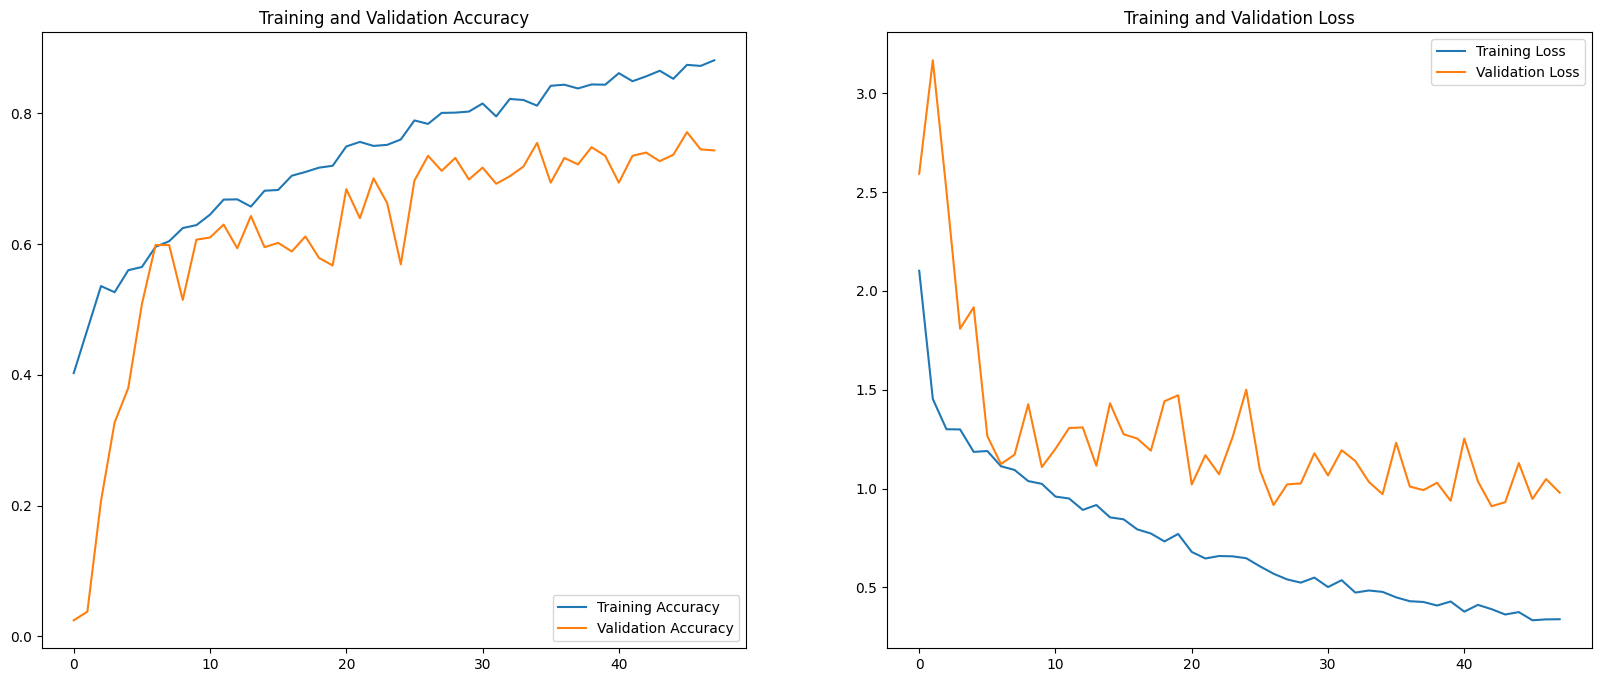

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(48)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

*The model is more fit, accuracy looks more improve: train accuracy ~88,1% and validation accuracy ~77%*

**=> Using combination of pre-approach and BatchNormallize which has ability to fix distribution input througout each layers improves not-fit problems and increase accuracy on model trianing on small dataset.**

##Test with pre-trained model
___

In [ ]:
import glob
import os
from PIL import Image
image_list = []
for filename in glob.glob('/content/drive/MyDrive/PBL5-Data/Data/data_3/*/*.jpg'): #assuming jpg
    try:
      im=Image.open(filename)
      image_list.append(im)
    except:
      print(filename)

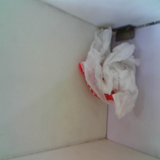

In [ ]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.image_list[].resize((160,160)).show()

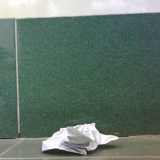

1/1 [==============================] - 0s 97ms/step
This image most likely belongs to paper with a 16.91 percent confidence.


In [ ]:
from PIL import Image
img = Image.open("/content/drive/MyDrive/PBL5-Data/24-2-2023/giay/capture (1).jpg")
width, height = img.size   # Get dimensions
new_width = 500
new_height = 600
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

# Crop the center of the image
img = img.crop((left, top, right, bottom))
img = img.resize((160,160))
img.show()


# b_path = "/content/drive/MyDrive/PBL5-Data/24-2-2023/chai-nhua/capture (71).jpg"

# img = tf.keras.utils.load_img(
#     b_path
# )
# img.crop((0,0,160,160))
# img2.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

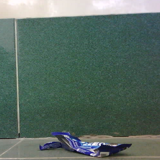

1/1 [==============================] - 0s 123ms/step
This image most likely belongs to cardboard with a 16.88 percent confidence.


In [ ]:
from PIL import Image
img = Image.open("/content/drive/MyDrive/PBL5-Data/24-2-2023/nilong/capture (43).jpg")
width, height = img.size   # Get dimensions
new_width = 500
new_height = 600
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

# Crop the center of the image
img = img.crop((left, top, right, bottom))
img = img.resize((160,160))
img.show()


# b_path = "/content/drive/MyDrive/PBL5-Data/24-2-2023/chai-nhua/capture (71).jpg"

# img = tf.keras.utils.load_img(
#     b_path
# )
# img.crop((0,0,160,160))
# img2.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(None,None,160,160,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

1/1 [==============================] - 1s 919ms/step
Predicted: [('n04086273', 'revolver', 0.522443), ('n03109150', 'corkscrew', 0.088820174), ('n02823428', 'beer_bottle', 0.07680627)]


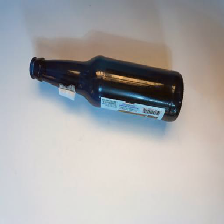

In [ ]:
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = '/content/drive/MyDrive/PBL5-Data/Garbage classification/glass/glass88.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
tensorflow.keras.utils.array_to_img(x.reshape(224,224,3))

1/1 [==============================] - 0s 229ms/step
Predicted: [('n03666591', 'lighter', 0.24991372), ('n04086273', 'revolver', 0.1810843), ('n03937543', 'pill_bottle', 0.12987505)]


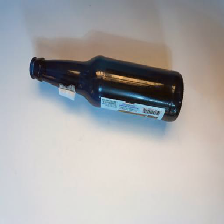

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet')
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

img_path = '/content/drive/MyDrive/PBL5-Data/Garbage classification/glass/glass88.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

block4_pool_features = base_model.predict(x)
print('Predicted:', decode_predictions(block4_pool_features, top=3)[0])
tensorflow.keras.utils.array_to_img(x.squeeze())